# Подготовительный этап

Установка торча, и PyG. 

In [ ]:
import torch

print(torch.__version__)

2.5.1+cpu


In [6]:
pip install torch_geometric


   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 5.1 MB/s eta 0:00:00


In [7]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cpu.html
     ---------------------------------------- 0.0/724.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/724.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/724.2 kB ? eta -:--:--
     -------------- ------------------------- 262.1/724.2 kB ? eta -:--:--
     -------------------------------------- 724.2/724.2 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/802.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/802.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/802.3 kB ? eta -:--:--
     ------------- -------------------------- 262.1/802.3 kB ? eta -:--:--
     -------------------------------------- 802.3/802.3 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [47]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Скачиваем датасет и проводим анализ

В качестве примера был взят датасет Cora, который представляет собой начную цитатную сеть, где узлы (nodes) - научные работы, рёбра (edges) - это ссылки (цитирования) между статьями, признаки (features) - bag of words из 1433 уникальных слов. Каждая статья принадлежит к одной из 7 тематических категорий (label), необходимо как раз предсказать по BoW какой label у статьи (то есть какая категория).

In [48]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [49]:
len(dataset)

1

Данный датасет содержит только один граф, рассмотрим его 

In [50]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

`x=[2708, 1433]` представляет собой Node feature matrix, то есть она описывает особенности узлов. Первая величина характеризует общее количество узлов, а вторая величина - количество признаков у одного узла.
`edge_index=[2, 10556]` описывает собой рёбра графов в COO формате. В этом формате в первой строке содержатся узлы из которых идёт связь, а под ними, во второй строке, номер узла в который эта связь заходит. Таким образом общее количество связей в данном графе - 10556.
`y=[2708]` описывает метку класса этих узлов.
`train_mask=[2708], val_mask=[2708], test_mask=[2708]` описывают какие узлы используются для обучения, валидации и теста соответственно. Если их рассмотреть то там будут булевые значения 0/1. Соответственно 0 - данный узел не используется в соотв. маске, 1 - используется. Рассмотрим, в какой пропорции разделены эти данные:

In [51]:
print(f'В train находится {data.train_mask.sum().item()} образцов;')
print(f'В val находится {data.val_mask.sum().item()} образцов;')
print(f'В test находится {data.test_mask.sum().item()} образцов;')


В train находится 140 образцов;
В val находится 500 образцов;
В test находится 1000 образцов;


Рассмотрим признаки первой статьи:

In [52]:
print(data.x[0].sum().item()) 

9.0


Всего 9 слов из 1433 были замечены в данной статье.

In [53]:
# Соберём небольшу информацию о графе
print(f'Количество узлов: {data.num_nodes}')
print(f'Количество связей: {data.num_edges}')
print(f'Среднее количество связей у одного узла: {data.num_edges / data.num_nodes:.2f}')
print(f'Количество узлов для обучения: {data.train_mask.sum()}')
print(f'Доля узлов для обучения: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Есть изолированные узлы: {data.has_isolated_nodes()}')
print(f'Есть циклы: {data.has_self_loops()}')
print(f'Граф направленный: {data.is_directed()}')
print(f'Граф сжатый: {data.is_coalesced()}')

Количество узлов: 2708
Количество связей: 10556
Среднее количество связей у одного узла: 3.90
Количество узлов для обучения: 140
Доля узлов для обучения: 0.05
Есть изолированные узлы: False
Есть циклы: False
Граф направленный: False
Граф сжатый: False


In [54]:
print(data.edge_index.t())

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])


Как видно, ребра описываются парой чисел, где первое характеризует узел из которого идёт ребро, а второе число - узел, в который это ребро заходит. Это и есть COO формат и он часто используется для описания разреженных (sparce) матриц, т.е. таких матриц, где много элементов равны 0.

Для отображения графа визуаьлно перейдём в формат `networkx` библиотеки:

In [55]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


edges: 10556


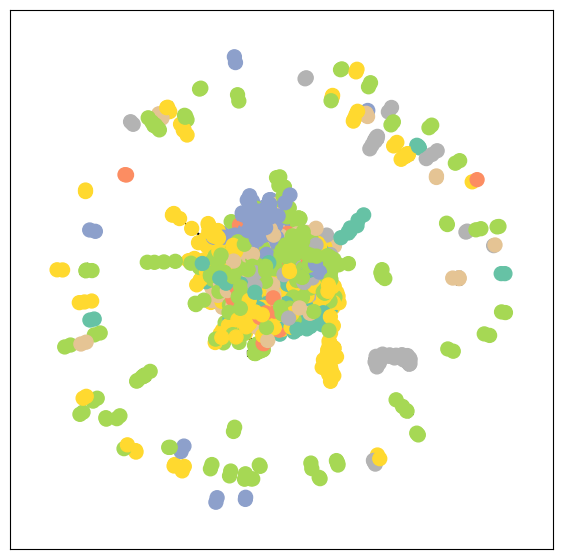

In [56]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

G = to_networkx(data, to_undirected=True)
G = nx.DiGraph(G)
print(f'edges: {G.number_of_edges()}')
node_color = data.y.numpy() if hasattr(data.y, 'numpy') else data.y

plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                 node_size = 100, node_color=data.y, cmap='Set2')
plt.show()

Почему-то не получается никак отобразить рёбра на графе.

# Создание модели

В ходе данной работы используется модель пространственной (spatial) парадигмы, а именно сети с использованием GCN. Данная парадигма основывается на алгоритме передаче сообщений: 

![message_passing](message_passing.svg)

In [57]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [38]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7870


Получили точность 78.70 процентов. 